Things to do
- Get AIF datasets
- Train on positive pairs for fairness
- Generate synthetic testing pairs
- Evaluate fairness
- Code up a booster

In [1]:
!pip install git+https://github.com/clabrugere/pytorch-scarf.git
!pip install aif360
!pip install tqdm
!pip install pandas
!pip install scikit-learn
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

  Cloning https://github.com/clabrugere/pytorch-scarf.git to c:\users\mxian\appdata\local\temp\pip-req-build-jehjnxcb
  Resolved https://github.com/clabrugere/pytorch-scarf.git to commit 3cc5b0641fdd1acedb9784f84e3cab68cf6015a3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ---------------------------------------- 61.1/61.1 kB 3.2 MB/s eta 0:00:00
  Using cached filelock-3.13.4-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1

  Running command git clone --filter=blob:none --quiet https://github.com/clabrugere/pytorch-scarf.git 'C:\Users\mxian\AppData\Local\Temp\pip-req-build-jehjnxcb'


  Using cached aif360-0.6.1-py3-none-any.whl.metadata (5.0 kB)
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -------------------------------------- 162.8/162.8 kB 9.5 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached aif360-0.6.1-py3-none-any.whl (259 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - ----------------------------------

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
     ---- ----------------------------------- 0.5/4.9 MB 10.5 MB/s eta 0:00:01
     --------- ------------------------------ 1.2/4.9 MB 12.2 MB/s eta 0:00:01
     --------------- ------------------------ 1.8/4.9 MB 13.0 MB/s eta 0:00:01
     -------------------- ------------------- 2.5/4.9 MB 13.0 MB/s eta 0:00:01
     -------------------------- ------------- 3.3/4.9 MB 13.8 MB/s eta 0:00:01
     ------------------------------- -------- 3.9/4.9 MB 13.9 MB/s eta 0:00:01
     -------------------------------------- - 4.7/4.9 MB 14.3 MB/s eta 0:00:01
     ---------------------------------------- 4.9/4.9 MB 13.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ------- -------------------------------- 0.7/4.0 MB 15.3 MB/s eta 0:00:01
     ------------- -------------------------- 1.3/4.0 MB 14.1 MB/s eta 0:00:01
     ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scarf 0.1 requires torch==2.2, but you have torch 2.3.0+cu118 which is incompatible.


     ------------- -------------------------- 0.9/2.7 GB 12.1 MB/s eta 0:02:24
     ------------- -------------------------- 0.9/2.7 GB 12.1 MB/s eta 0:02:24
     ------------- -------------------------- 0.9/2.7 GB 11.9 MB/s eta 0:02:27
     ------------- -------------------------- 0.9/2.7 GB 12.1 MB/s eta 0:02:24
     ------------- -------------------------- 0.9/2.7 GB 12.1 MB/s eta 0:02:24
     ------------- -------------------------- 0.9/2.7 GB 11.9 MB/s eta 0:02:27
     ------------- -------------------------- 0.9/2.7 GB 12.1 MB/s eta 0:02:24
     ------------- -------------------------- 0.9/2.7 GB 11.7 MB/s eta 0:02:29
     ------------- -------------------------- 0.9/2.7 GB 11.3 MB/s eta 0:02:35
     ------------- -------------------------- 0.9/2.7 GB 10.7 MB/s eta 0:02:43
     ------------- -------------------------- 0.9/2.7 GB 10.4 MB/s eta 0:02:48
     ------------- -------------------------- 0.9/2.7 GB 9.8 MB/s eta 0:02:59
     ------------- -------------------------- 0.9/2.7

In [2]:
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.3.0+cu118
**********
_CUDA version: 
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [12]:
# Imports
from scarf.loss import NTXent
from scarf.model import SCARF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from tqdm import tqdm
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
# Hyperparameters & Helper Functions
def dataset_embeddings(model, loader, device):
    embeddings = []

    for x in tqdm(loader):
        x = x.to(device)
        embeddings.append(model.get_embeddings(x))

    embeddings = torch.cat(embeddings).cpu().numpy()

    return embeddings


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


batch_size = 128
epochs = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1234
fix_seed(seed)

In [5]:
class SCARFDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    @property
    def features_low(self):
        return self.data.min(axis=0)

    @property
    def features_high(self):
        return self.data.max(axis=0)

    @property
    def shape(self):
        return self.data.shape

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [6]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, stratify=target, random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
train_ds = SCARFDataset(
    train_data.to_numpy(), train_target.to_numpy(), columns=train_data.columns
)
test_ds = SCARFDataset(
    test_data.to_numpy(), test_target.to_numpy(), columns=test_data.columns
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [7]:
# Model
model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = NTXent()

In [9]:
# Training
loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        emb_anchor, emb_positive = model(x)

        loss = criterion(emb_anchor, emb_positive)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")

epoch 100/5000 - loss: 19.9746
epoch 200/5000 - loss: 19.8497
epoch 300/5000 - loss: 19.9742
epoch 400/5000 - loss: 19.8469
epoch 500/5000 - loss: 19.9338
epoch 600/5000 - loss: 19.7580
epoch 700/5000 - loss: 19.8891
epoch 800/5000 - loss: 19.6494
epoch 900/5000 - loss: 19.6983
epoch 1000/5000 - loss: 19.7697
epoch 1100/5000 - loss: 19.6095
epoch 1200/5000 - loss: 19.6445
epoch 1300/5000 - loss: 19.5594
epoch 1400/5000 - loss: 19.7530
epoch 1500/5000 - loss: 19.6360
epoch 1600/5000 - loss: 19.5682
epoch 1700/5000 - loss: 19.6496
epoch 1800/5000 - loss: 19.5435
epoch 1900/5000 - loss: 19.5510
epoch 2000/5000 - loss: 19.6357
epoch 2100/5000 - loss: 19.4447
epoch 2200/5000 - loss: 19.5921
epoch 2300/5000 - loss: 19.4980
epoch 2400/5000 - loss: 19.5323
epoch 2500/5000 - loss: 19.5098
epoch 2600/5000 - loss: 19.4849
epoch 2700/5000 - loss: 19.4563
epoch 2800/5000 - loss: 19.5253
epoch 2900/5000 - loss: 19.4690
epoch 3000/5000 - loss: 19.3604
epoch 3100/5000 - loss: 19.4636
epoch 3200/5000 -

Text(0, 0.5, 'loss')

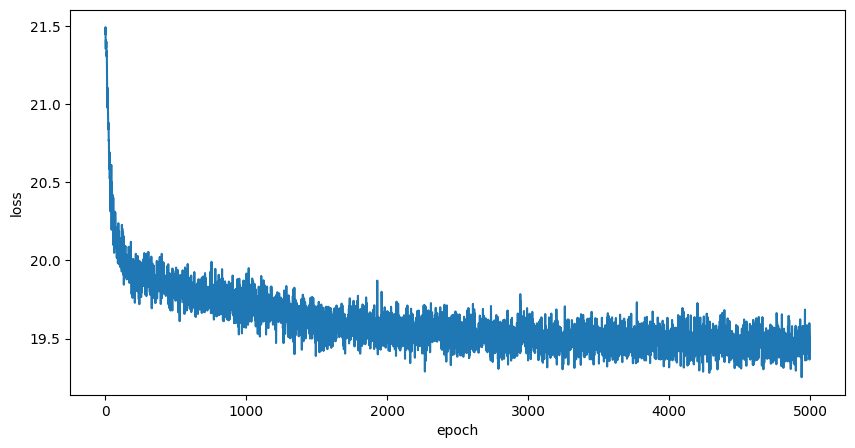

In [10]:
# Plot loss history

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [13]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 1/1 [00:00<00:00, 251.02it/s]

(455, 8)
(114, 8)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



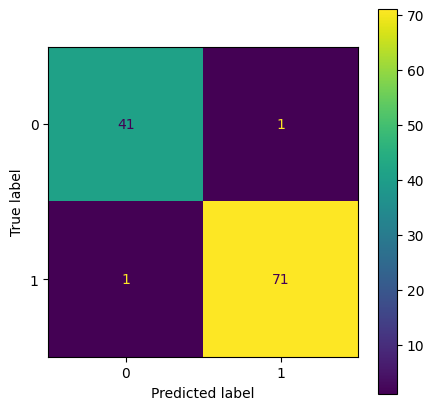

In [20]:
clf_vanilla = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf_vanilla.fit(train_data, train_target)
vanilla_predictions = clf_vanilla.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        42
           1       0.90      0.96      0.93        72

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.90      0.90      0.90       114



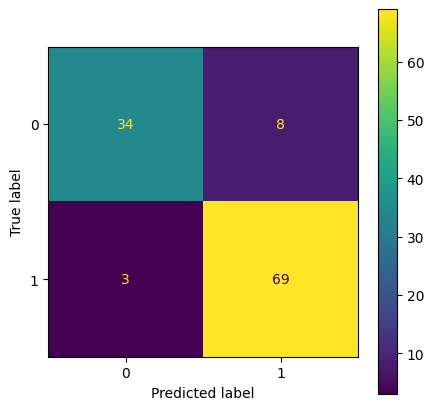

In [21]:
# embeddings dataset: train the classifier on the embeddings
clf = LogisticRegression()
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

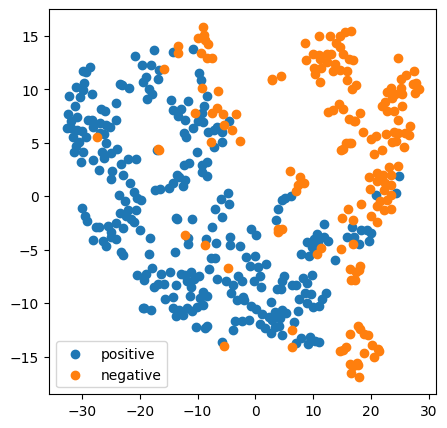

In [22]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

In [79]:
# Generate synthetic Data for fairness testing
def generate_synthetic_data(df):
    synthetic_data = {}
    for column in df.columns:
        if df[column].dtype == "int64" or df[column].dtype == "float64":
            min_value = df[column].min()
            max_value = df[column].max()
            synthetic_data[column] = np.random.uniform(
                min_value, max_value, size=len(df)
            )
        elif df[column].dtype == "object":
            unique_values = df[column].unique()
            synthetic_data[column] = np.random.choice(unique_values, size=len(df))
        elif df[column].dtype == "bool":
            synthetic_data[column] = np.random.choice([True, False], size=len(df))
        else:
            synthetic_data[column] = [np.nan] * len(df)

    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
    return synthetic_df

fairness_test_df = generate_synthetic_data(train_data)
fairness_test_ds = SCARFDataset(
    fairness_test_df.to_numpy(),
    train_target.to_numpy(),
    columns=fairness_test_df.columns,
)  # The other 2 columns don't really matter

fairness_test_loader = DataLoader(
    fairness_test_ds, batch_size=batch_size, shuffle=False
)


In [83]:
# Testing Fairness
protected_indices = [0, 1]
protected = ["mean radius", "mean texture"]

fairness_vanilla = []
fairness_embed = []

model.eval()

for _, x in fairness_test_df.iterrows():
    x_copy = x.to_frame().T
    for attribute in protected:
        x_copy[attribute] = 1 - x_copy[attribute]

    vanilla_x = clf_vanilla.predict(x.values.reshape(1, -1))
    vanilla_x_copy = clf_vanilla.predict(x_copy.values.reshape(1, -1))
    fairness_vanilla.append(1 if vanilla_x == vanilla_x_copy else 0)

for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    cl_x, cl_x_copy = clf.predict(embed_x), clf.predict(embed_x_copy)
    for (embed_pred_x, embed_pred_x_copy) in zip(cl_x, cl_x_copy):
        fairness_embed.append(1 if embed_pred_x == embed_pred_x_copy else 0)

vanilla_fair_score = np.mean(np.array(fairness_vanilla))
embed_fair_score = np.mean(np.array(fairness_embed))

In [86]:
print(vanilla_fair_score)
print(embed_fair_score)

0.9978021978021978
0.9868131868131869
